In [2]:
import pandas as pd
import shutil
import os
import SimpleITK as sitk
import numpy as np
from pathlib import Path
from scipy import ndimage
from skimage import measure

In [3]:
def create_binary_mask(cmr_volume, myocardium_prediction, threshold_value, min_expansion):

    # Convert the images to numpy arrays
    prediction_array = sitk.GetArrayFromImage(myocardium_prediction)

    # Initialize an empty binary mask
    binary_mask = np.zeros_like(prediction_array)

    # Iterate over slices
    structure = ndimage.generate_binary_structure(2, 2)
    for slice_index in range(myocardium_prediction.GetDepth()):
        # Get the 2D slice and the corresponding binary mask slice
        binary_mask_slice_b = sitk.Extract(myocardium_prediction, (myocardium_prediction.GetWidth(), myocardium_prediction.GetHeight(), 0), (0, 0, slice_index))

        # Threshold the original slice to create a binary mask
        binary_mask_slice = sitk.BinaryThreshold(binary_mask_slice_b, lowerThreshold=threshold_value, insideValue=1, outsideValue=0)

        # slice_mask = (myocardium_mask_array[slice_index] >= threshold_value).astype(np.uint8)
        ##### Step 2 : Morphological closing --> fill the pixels with 0 inside ROI with 1 (fill the holes inside the ROI)
        # Apply a binary closing operation
        closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
        closing_filter.SetKernelRadius([6, 6])
        binary_mask_slice = closing_filter.Execute(binary_mask_slice)
        binary_mask_array = sitk.GetArrayFromImage(binary_mask_slice)

        contour_mask = np.zeros_like(binary_mask_array)

        contours = measure.find_contours(binary_mask_array) 
        # Count the number of pixels with a value of 1
        count_ones = np.count_nonzero(binary_mask_array == 1)

        if count_ones >= min_expansion:
            for i, contour in enumerate(contours):
                    if i < 1:
                        for point in contour:
                            contour_mask[int(point[0]), int(point[1])] = 1
        
        binary_mask[slice_index] = ndimage.binary_fill_holes(contour_mask).astype(int)
        binary_mask[slice_index] = ndimage.binary_dilation(binary_mask[slice_index],  iterations=1, structure=structure).astype(int)
        count_ones = np.count_nonzero(binary_mask[slice_index] == 1)

        if count_ones > 800:
            binary_mask[slice_index] = ndimage.binary_fill_holes(binary_mask[slice_index]).astype(int)
        else:
            binary_mask[slice_index] = 0

    # Convert the binary mask back to SimpleITK image
    binary_mask_image = sitk.GetImageFromArray(binary_mask)
    binary_mask_image.CopyInformation(cmr_volume)

    return binary_mask_image

In [5]:
def keep_non_zero_slices(original_3d_image, myoseg, binary_mask_image):
    # Initialize lists to store slices with non-zero values
    non_zero_slices_original = []
    non_zero_slices_mask = []
    non_zero_slices_myoseg = []
    # Iterate over slices
    # source_size= = original_3d_image.GetSize()
    for slice_nr in range(original_3d_image.GetDepth()):
        # Extract 2D slices
        original_slice = sitk.Extract(original_3d_image, (original_3d_image.GetWidth(), original_3d_image.GetHeight(), 0), (0, 0, slice_nr))
        mask_slice = sitk.Extract(binary_mask_image, (binary_mask_image.GetWidth(), binary_mask_image.GetHeight(), 0), (0, 0, slice_nr))
        myoseg_slice = sitk.Extract(myoseg, (myoseg.GetWidth(), myoseg.GetHeight(), 0), (0, 0, slice_nr))
        # Convert slices to NumPy arrays
        # original_array = sitk.GetArrayFromImage(original_slice)
        mask_array = sitk.GetArrayFromImage(mask_slice)

        # Check if the mask slice has any non-zero values
        if np.any(mask_array != 0):
            non_zero_slices_original.append(original_slice)
            non_zero_slices_mask.append(mask_slice)
            non_zero_slices_myoseg.append(myoseg_slice)
    if len(non_zero_slices_original) > 4:
        # Merge the non-zero slices back into 3D images
        non_zero_slices_original_3d = sitk.JoinSeries(non_zero_slices_original)
        non_zero_slices_original_3d.SetDirection(original_3d_image.GetDirection())
        non_zero_slices_original_3d.SetOrigin(original_3d_image.GetOrigin())
        non_zero_slices_original_3d.SetSpacing(original_3d_image.GetSpacing())

        # non_zero_slices_original_3d.CopyInformation(original_3d_image)

        non_zero_slices_mask_3d = sitk.JoinSeries(non_zero_slices_mask)
        non_zero_slices_mask_3d.SetDirection(original_3d_image.GetDirection())
        non_zero_slices_mask_3d.SetOrigin(original_3d_image.GetOrigin())
        non_zero_slices_mask_3d.SetSpacing(original_3d_image.GetSpacing())
        
        non_zero_slices_myoseg_3d = sitk.JoinSeries(non_zero_slices_myoseg)
        non_zero_slices_myoseg_3d.SetDirection(original_3d_image.GetDirection())
        non_zero_slices_myoseg_3d.SetOrigin(original_3d_image.GetOrigin())
        non_zero_slices_myoseg_3d.SetSpacing(original_3d_image.GetSpacing())
    else:
        return None, None, None
    return non_zero_slices_original_3d, non_zero_slices_mask_3d,  non_zero_slices_myoseg_3d

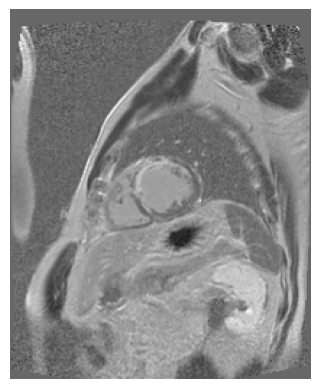

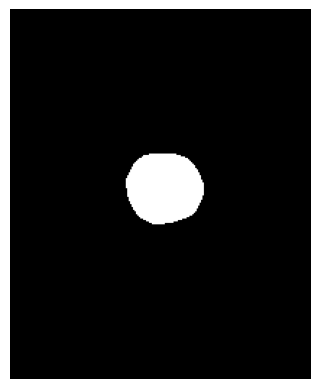

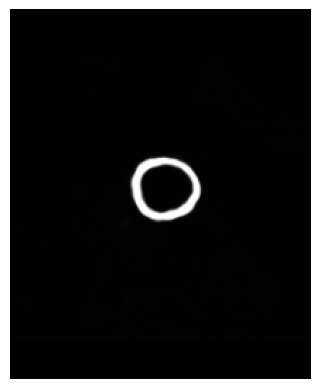

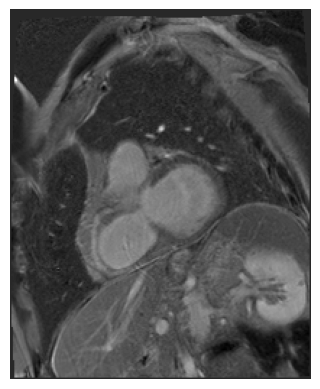

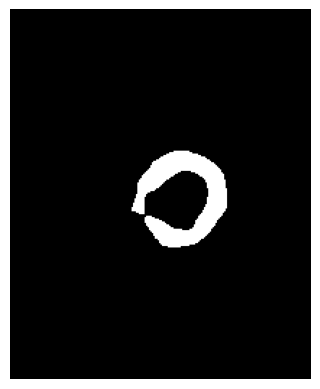

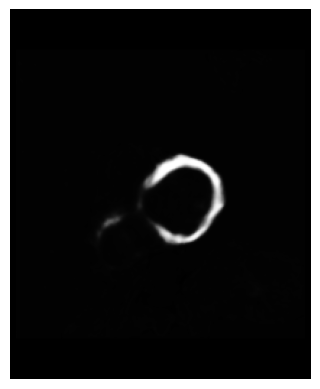

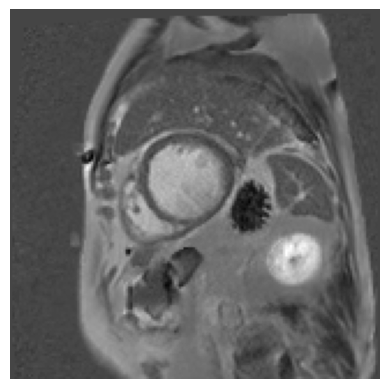

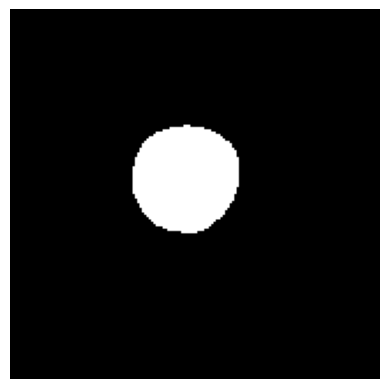

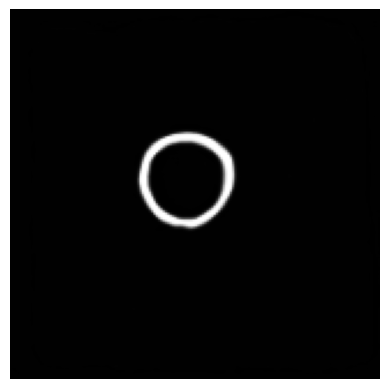

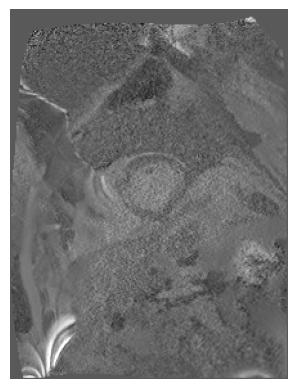

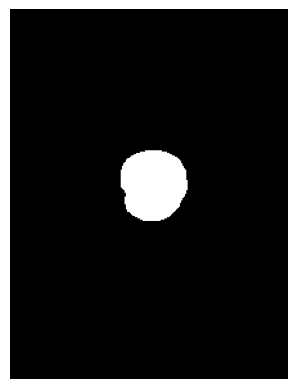

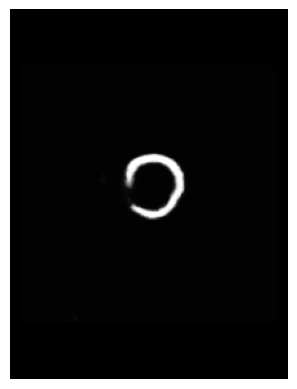

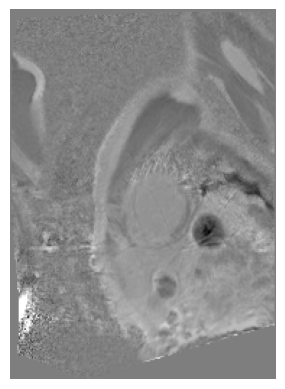

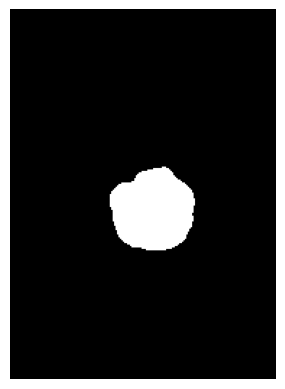

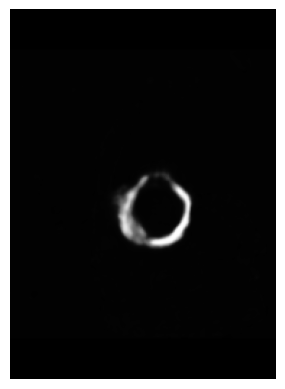

AttributeError: 'NoneType' object has no attribute 'GetPixelIDValue'

In [7]:
clinical_data_path = 'L:\\basic\\Personal Archive\\E\\emquist\\parsing_MRI\\final_test_seg\\LOG\\clin_merged_lge_ICM_non_dup_filtered_1y.csv'
clinical_df = pd.read_csv(clinical_data_path)
lge_og_path = 'L:\\basic\Personal Archive\E\emquist\parsing_MRI\\final_test_seg\lge_sax_psir_mri_good_shape'
myo_og_path =  'L:\\basic\Personal Archive\E\emquist\parsing_MRI\\final_test_seg\myo_pred_all_lge'
vae_data_path = 'L:\\basic\\Personal Archive\\E\\emquist\\parsing_MRI\\final_test_seg\\LGE_clin_myo_ICM_labeled_filtered_1y'

for index, row in clinical_df.iterrows():
    full_lge_og_path = os.path.join(lge_og_path, str(row['LGE_number']) + '_' + row['LGE_filename'])
    myo_pred_filename = f"{str(row['LGE_number']) + '_' +row['LGE_filename'][:-7]}_myo_pred.nrrd"
    full_myo_og_path = os.path.join(myo_og_path, myo_pred_filename)

    img = sitk.ReadImage(full_lge_og_path)
    myoseg = sitk.ReadImage(str(full_myo_og_path))

    # Example usage
    threshold = 0.05  # Adjust the threshold as needed
    min_expansion = 150  # Adjust the minimum expansion as needed
    binary_mask_image = create_binary_mask(img, myoseg, threshold, min_expansion)
    # binary_mask_image = sitk.Cast(binary_mask_image, sitk.sitkFloat64)

    non_zero_slices_original_3d, non_zero_slices_mask_3d, non_zero_slices_myoseg_3d  = keep_non_zero_slices(img, myoseg, binary_mask_image)
    if non_zero_slices_original_3d is not None:

        mortality_label = int(row.loc['Mortality'])
        therapy_label = int(row.loc['AppropriateTherapy'])
        if mortality_label == 0:
            mort_live = 'L'
        if mortality_label == 1:
            mort_live = 'M'
        if therapy_label == 0:
            appropriate = 'N'
        if therapy_label == 1:
            appropriate = 'Y'

        new_path = f"{vae_data_path}/{index}_{mort_live}_{appropriate}_{row['StudyID']}_{row['MRI_ID']}"

        if not os.path.exists(new_path):
            os.makedirs(new_path, exist_ok=True)


        row.to_csv( f"{new_path}/clin_{index}.csv", index=True)

        # Save preprocessed image as NIfTI
        output_path_image = f"{new_path}/LGE_{index}_{mort_live}_{appropriate}.nii.gz"
        output_path_mask =  f"{new_path}/MASK_{index}_{mort_live}_{appropriate}.nii.gz"
        output_path_myo = f"{new_path}/MYO_{index}_{mort_live}_{appropriate}.nrrd"

        # Save the resulting images
        sitk.WriteImage(non_zero_slices_original_3d, output_path_image)
        sitk.WriteImage(non_zero_slices_mask_3d, output_path_mask)
        sitk.WriteImage(non_zero_slices_myoseg_3d, output_path_myo)

In [6]:
clinical_data_path = 'L:\\basic\\Personal Archive\\E\\emquist\\parsing_MRI\\final_test_seg\\LOG\\clin_merged_lge_cine.csv'
clinical_df = pd.read_csv(clinical_data_path)
lge_og_path = 'L:\\basic\Personal Archive\E\emquist\parsing_MRI\\final_test_seg\lge_sax_psir_mri_good_shape'
cine_og_path = 'L:\\basic\Personal Archive\E\emquist\parsing_MRI\\final_test_seg\cine_sax_mri_good_shape'
myo_og_path =  'L:\\basic\Personal Archive\E\emquist\parsing_MRI\\final_test_seg\myo_pred_all_lge'
vae_data_path = 'L:\\basic\\Personal Archive\\E\\emquist\\parsing_MRI\\final_test_seg\\VAE_LGE_CINE_clin_merged'

for index, row in clinical_df.iterrows():
    full_lge_og_path = os.path.join(lge_og_path, str(row['LGE_number']) + '_' + row['LGE_filename'])
    full_cine_og_path = os.path.join(cine_og_path, str(row['CINE_number']) + '_' + row['CINE_filename'])

    myo_pred_filename = f"{str(row['LGE_number']) + '_' +row['LGE_filename'][:-7]}_myo_pred.nrrd"
    full_myo_og_path = os.path.join(myo_og_path, myo_pred_filename)
    
    new_path = f"{vae_data_path}/{index}_{row['StudyID']}_{row['MRI_ID']}"
    if not os.path.exists(new_path):
        os.makedirs(new_path, exist_ok=True)

    shutil.copy2(full_lge_og_path, f"{new_path}/LGE_{index}.nii.gz")
    shutil.copy2(full_cine_og_path, f"{new_path}/CINE_{index}.nii.gz")
    shutil.copy2(full_myo_og_path, f"{new_path}/MYO_{index}.nrrd")
    row.to_csv( f"{new_path}/clin_{index}.csv", index=True)